# Prediction whit Multiple Regression

Nuestra tarea será la de generar un modelo de regresión múltiple que asigne a cada vino según su composición, un puntaje que podría recibir por parte de catadores expertos en esta varidad de vino (rojo/tinto).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

from dmba.featureSelection import stepwise_selection
from dmba.metric import AIC_score

### Carga y análisis de datos

In [2]:
data = pd.read_csv('data/winequality-red.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
y = 'quality'

In [5]:
data.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

La tarea la dividiré entre la elección de las variables más adecuadas para realizar nuestra predicción, y la validación de nuestro modelo y sus estadísticas más significativas.

Por suerte, nuestro Dataset viene ya con una muy buena descripción de sus variables que nos permitirán ver su importancia (inicialmente )a la hora de predecir nuestro valor.

### Feature selection

Revisaremos las variables desde 3 ángulos, realizando una preselección en cada caso, y quedandonos con unos predictores finales de acuerdo a esta revisión:

In [6]:
features = list(data.columns)
features.remove(y)
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

<b>Según su relevancia en el sector vitivinícola</b>

Las cinco características fundamentales que se suelen señalar son: dulzor, acidez, tanino, ácido acético y alcohol, y su comportamiento entre ellas. Elegiremos las variables más representativas de estas características.

In [7]:
selection1 = ['fixed acidity','volatile acidity','residual sugar','total sulfur dioxide','density','pH','alcohol']

<b>Según la correlación directa entre variables</b>

Ahora, analizaremos la correlación que nos brinda el método .corr() através de un mapa de color para una interpretación mas fluida.

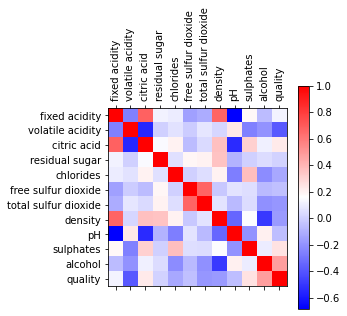

In [8]:
matriz = data.corr()

plt.matshow(matriz, cmap='bwr') #Se genera una matriz de color (gráfica), con los colores indicados
plt.xticks(range(12),data.columns,rotation=90) #Coloca los nombres de los atributos en los ejes
plt.yticks(range(12),data.columns)
plt.colorbar() #Pone una barra de colores con escala para mejor apreciación
plt.show()

In [9]:
matriz.quality

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
quality                 1.000000
Name: quality, dtype: float64

Ya desde la gráfica se ve que con nuestra variable objetivo quality, hay varias variables que podríamos eliminar como predictoras. Por lo que pondremos un filtro sobre aquellas que obtengan valores absolutos menor a 0.15.

In [10]:
selection2 = ['volatile acidity','citric acid','total sulfur dioxide','density','sulphates','alcohol']

<b>Stepwise Selection</b>

Utilizaremos ahora, el método de Stepwise Selection para poder descartar por los valores estadísticos menos relevantes, a las variables que no proporcionarían un buen rendimiento al modelo.

In [11]:
def train(variables):
    if len(variables)==0:
        return None
    model = LinearRegression()
    model.fit(data[variables],data[y])
    return model

def score_model(model,variables):
    if len(variables)==0:
        return None
    return AIC_score(data[y],model.predict(data[variables]),model=model) #(y_true, y_pred, model=None, df=None)

best = stepwise_selection(features,train_model=train,score_model=score_model, direction='backward',verbose=True)

Variables: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol
Start: score=3164.28, constant
Step: score=3162.96, remove density
Step: score=3161.22, remove fixed acidity
Step: score=3159.84, remove residual sugar
Step: score=3158.98, remove citric acid
Step: score=3158.98, unchanged None


In [12]:
selection3 = list(best[1])
selection3

['volatile acidity',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol']

Ahora, que ya tenemos nuestras tres selecciones hechas, vamos a aplicar nuestro criterio para poder definir nuestros predictores finales

In [13]:
print(f'{selection1}\n{selection2}\n{selection3}')

['fixed acidity', 'volatile acidity', 'residual sugar', 'total sulfur dioxide', 'density', 'pH', 'alcohol']
['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']


In [14]:
predictors = ['volatile acidity','total sulfur dioxide','alcohol','density','pH','sulphates']

Veremos si nuestros predictores poseen alguna distribución que debamos limpiar y/o ordenar

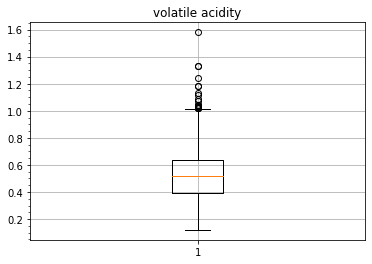

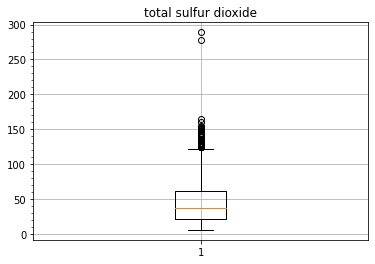

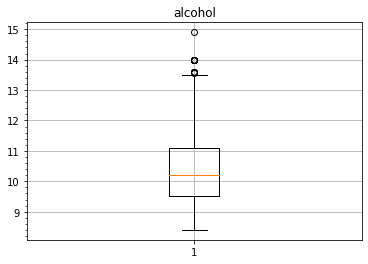

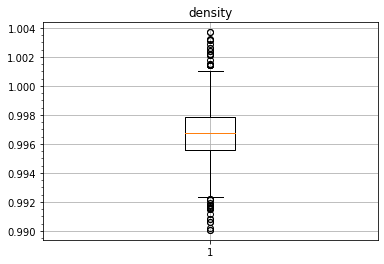

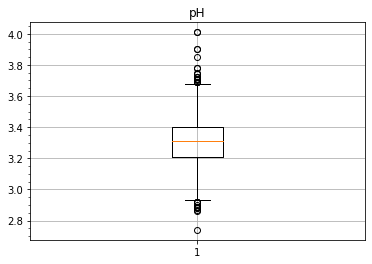

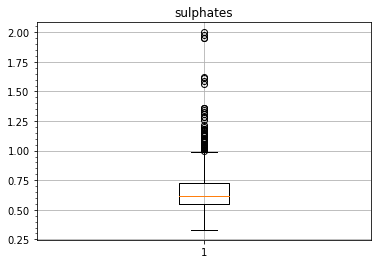

In [15]:
for x in predictors:
    figplot = plt.figure()

    plt.boxplot(data[x])

    plt.title(x)
    plt.grid()
    plt.minorticks_on()

    plt.show()

    figplot.savefig(f'images/boxplox-{x}.jpeg')

In [16]:
clean_data = data[data['volatile acidity']<10.5]
clean_data = clean_data[clean_data['total sulfur dioxide']<125]
clean_data = clean_data[clean_data['alcohol']<13.5]
clean_data = clean_data[(clean_data['density']<1.001)&(clean_data['density']>0.9925)]
clean_data = clean_data[(clean_data['pH']<3.7)&(clean_data['pH']>2.9)]
clean_data = clean_data[clean_data['sulphates']<1]
clean_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [17]:
clean_data.quality.value_counts()

5    598
6    583
7    172
4     47
8     12
3     10
Name: quality, dtype: int64

### Armado del modelo y obtención de sus métricas

Procederemos a generar el modelo y revisar sus métricas principales

In [18]:
modelo = LinearRegression()
modelo.fit(clean_data[predictors],clean_data[y])
score = modelo.score(clean_data[predictors],clean_data[y])
score

0.3659698219639492

Ante la baja puntuación, nos interesa ver si tal vez la razón provenga de los features que hemos elegido como predictores

In [19]:
other_predictors=[selection1,selection2,selection3,features]
for x in other_predictors:
    modelo_prueba = LinearRegression()
    modelo_prueba.fit(clean_data[x],clean_data[y])
    score = modelo_prueba.score(clean_data[x],clean_data[y])
    print(score)

0.3209164605383018
0.35809136166846656
0.37078504051335215
0.3732469023095074


Como vemos que mi puntuación corresponde al promedio de todas las combinaciones anteriores, concluyo que mi selección estuvo acertada.

Analicemos más a fondo el modelo:

In [20]:
modelOLS = sm.OLS(clean_data[y],clean_data[predictors].assign(const=1)) #El término final es necesario para que opere con matrices
results = modelOLS.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     136.1
Date:                Wed, 25 May 2022   Prob (F-statistic):          3.33e-136
Time:                        17:15:16   Log-Likelihood:                -1369.7
No. Observations:                1422   AIC:                             2753.
Df Residuals:                    1415   BIC:                             2790.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
volatile acidity        -0.9064      0.107     -8.461      0.000      -1.117      -0.696
total sulfur dioxide    -0.0020      0.001     -3.027      0.003      -0.003      -0.001
alcohol                  0.2702      0.021     12.587      0.000       0.228       0.312
density                -18.2525     12.715     -1.435      0.151     -43.195       6.690
pH                      -0.5650      0.134     -4.221      0.000      -0.828      -0.302
sulphates                1.6248      0.161     10.121      0.000       1.310       1.940
const                   22.4191     12.873      1.742      0.082      -2.834      47.672
==============================================================================
Omnibus:                       27.137   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.766
Skew:                          -0.203   Prob(JB):                     3.82e-09
Kurtosis:                       3.700   Cond. No.                     5.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

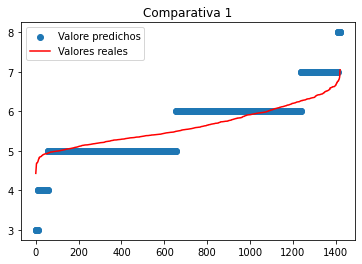

In [21]:
y_predicho = modelo.predict(clean_data[predictors])

fig1 = plt.figure()
plt.scatter([x for x in range(len(y_predicho))],clean_data[y].sort_values(),label='Valore predichos')
plt.plot([x for x in range(len(y_predicho))],np.sort(y_predicho),color='r',label='Valores reales')
plt.legend()
plt.title('Comparativa 1')
plt.show()
fig1.savefig('images/Comparativa1.jpeg')

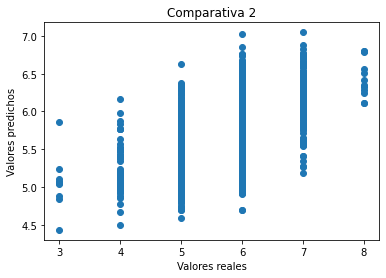

In [22]:
fig2 = plt.figure()
plt.scatter(clean_data[y],y_predicho)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Comparativa 2')
plt.show()
fig2.savefig('images/Comparativa2.jpeg')

Como se puede apreciar, nuestro modelo se ajusta bastante a las pendientes presentadas en los datos, pero debido a la gran cantidad de registros con puntuaciones medias (o muy pocas con alta y baja puntuación), la recta del modelo no logra ajustarse correctamente. Tambien justifica esta conjetura como el score aumenta por más que incluya más predictores indiscriminadamente, ya que esto le da al modelo más flexibilidad en sus curvas. Intentaremos ver que pasa si quitamos los datos de los extremos y/o los centrales:

In [23]:
clean_data2 = clean_data[(clean_data['quality']< 8) & (clean_data['quality'] > 4)]
modelo2 = LinearRegression()
modelo2.fit(clean_data2[predictors],clean_data2[y])
score2 = modelo2.score(clean_data2[predictors],clean_data2[y])
print(f'Modelo para valores entre 5 y 7\nCantidad de valores: {len(clean_data2)}. Score: {score2}')

Modelo para valores entre 5 y 7
Cantidad de valores: 1353. Score: 0.3700014278629108


In [24]:
clean_data3 = clean_data[(clean_data['quality']>7) | (clean_data['quality'] < 4)]
modelo3 = LinearRegression()
modelo3.fit(clean_data3[predictors],clean_data3[y])
score3 = modelo3.score(clean_data3[predictors],clean_data3[y])
print(f'Modelo para valores menores a 4 y mayores a 8\nCantidad de valores: {len(clean_data3)}. Score: {score3}')

Modelo para valores menores a 4 y mayores a 8
Cantidad de valores: 22. Score: 0.9414631529536277


Si bien impresiona el gran resultado que podemos encontrar en un modelo en que calificamos vinos excelentes y muy malos, hemos de señalar que el gran ajuste se debe a la excasa cantidad de registros de estos vinos (solo 22), haciendo que nuestra recta se ajuste casi perfectamente a ellos. No obstante, confirmamos que incluso quitando los valores extremos, el modelo no logra ajustarse a los datos mas de un 37%.

Ante esto, podremos asumir que si implementamos cross validation, obtendremos métricas muy distintas entre sí, ya que al subdividir el conjunto volverán a quedar muy pocos, y posiblemente no distribuidos de forma pareja:

In [29]:
#Lo dejaremos en 5 subdivisiones para que los grupos de datos no sean tan pequeños y den resultados mas validos
cross_val_result = cross_val_score(modelo,clean_data[predictors],clean_data[y])
print('Cross Validation Result:')
for x in cross_val_result:
    print(x)
print(f'\nValor de la media: {cross_val_result.mean()}')

Cross Validation Result:
0.24167288013297927
0.35514341368427704
0.3952779498392931
0.3736510891246756
0.2544798969225658

Valor de la media: 0.3240450459407581


Lo mismo quedará evidenciado en los intervalos de confianza que podremos obtener de las posibles muestras

In [26]:
#Metodo Bootstrap
coef_list = []
for _ in range(1000):
    sample = clean_data.sample(1000)
    model = LinearRegression()
    model.fit(sample[predictors],sample[y])
    coef_list.append(model.coef_)
coeficientes = pd.DataFrame(coef_list,columns=predictors)

In [31]:
print('Confidence intervals:\n')
print(coeficientes.quantile(0.05))
print('')
print(coeficientes.quantile(0.95))

Confidence intervals:

volatile acidity        -1.031453
total sulfur dioxide    -0.002649
alcohol                  0.245330
density                -32.416357
pH                      -0.706802
sulphates                1.453195
Name: 0.05, dtype: float64

volatile acidity       -0.779890
total sulfur dioxide   -0.001296
alcohol                 0.293248
density                -4.746803
pH                     -0.408709
sulphates               1.788076
Name: 0.95, dtype: float64


### Conclusión

El modelo de regresión lineal múltiple, a pesar de estar correctamente planteado desde el conocimiento del sector, limpiado de outliers, y ajustado según las estadísticas, no logra superar un valor de score del 36.6%. Sin embargo, queda muy evidenciado la correlación de las variables entre sí en el analisis de datos, por lo que se debería encontrar otros modelos de regresión que nos permita obtener mejores resultados y predicciones.